In [1]:
import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import plotly.plotly as py
import plotly
import cufflinks as cf
import pprint
import json
import yaml

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.manifold import TSNE



paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [2]:
CONFIG_FILE = '../../../../../APIKeys/API.yaml'

with open(CONFIG_FILE, 'r') as config_file:
    config = yaml.load(config_file)

PLOTLY_USERNAME = config["plotly"]["PLOTLY_USERNAME"]
PLOTLY_API_KEY = config["plotly"]["PLOTLY_API_KEY"]

plotly.tools.set_credentials_file(username = PLOTLY_USERNAME, api_key = PLOTLY_API_KEY)



In [3]:
# main_data = pd.read_csv('../../business_news.csv')
# main_data = pd.read_csv('../../entrepreneurs_news.csv')
main_data = pd.read_csv('../../financial_news.csv')

main_data = main_data.sort_values(by = "Published")

news_data = main_data[["Snippet", "Lead Paragraph", "Main Headline"]]
news_data.apply(str)
main_data.head()

,Published,Snippet,Lead Paragraph,Main Headline,Print Headline,Seo Headline
977,2019-01-01T07:30:05+0000,Underperforming media deals have left the conf...,Underperforming media deals have left the conf...,Another Season Comes and Goes While Pac-12 Str...,A Power Conference’s Declining Clout,NaN
674,2019-01-01T14:00:04+0000,Recent commercial real estate transactions in ...,Recent commercial real estate transactions in ...,Recent Commercial Real Estate Transactions,Transactions,NaN
879,2019-01-01T17:47:14+0000,Skeptical reporting has still been too favorable.,Skeptical reporting has still been too favorable.,The Trump Tax Cut: Even Worse Than You’ve Heard,The Trump Tax Cut: Even Worse Than You’ve Heard,NaN
307,2019-01-01T21:21:40+0000,"The episode of “Patriot Act With Hasan Minhaj,...","The episode of “Patriot Act With Hasan Minhaj,...",Netflix Blocks Show in Saudi Arabia Critical o...,Netflix Blocks Show in Saudi Arabia Critical o...,NaN
357,2019-01-02T07:00:00+0000,This word has appeared in 10 articles on NYTim...,This word has appeared in 10 articles on NYTim...,Word + Quiz: agog,Word + Quiz: agog,NaN


In [4]:
# Grab all the titles 
article_titles = main_data['Main Headline']
# Create a list of strings, one for each title
titles_list = [title for title in article_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]


['another',
 'season',
 'comes',
 'goes',
 'struggles',
 'keep',
 'recent',
 'commercial',
 'real',
 'estate']

In [5]:
# Load word2vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('../resources/model/GoogleNews-vectors-negative300.bin', binary = True) 

# Check dimension of word vectors
model.vector_size


300

In [6]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.head(3)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
another,0.194336,-0.019653,0.091797,0.104492,-0.071777,-0.012390,-0.050293,-0.068848,0.000523,0.129883,...,0.019287,0.078125,-0.005219,0.052002,0.022339,0.006531,-0.043701,-0.074219,0.065918,-0.076172
season,0.059814,0.164062,-0.159180,0.061523,0.197266,-0.053711,0.076660,-0.060059,0.145508,0.431641,...,-0.053223,-0.081055,-0.162109,-0.168945,0.141602,0.009399,-0.018188,-0.109863,0.034180,-0.185547
comes,0.265625,0.037842,0.069336,-0.029419,-0.083984,-0.044678,0.105957,0.039307,0.125977,0.087402,...,-0.142578,-0.058838,-0.279297,0.230469,0.048828,-0.052734,0.101562,-0.022827,0.082031,0.246094


In [7]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df)


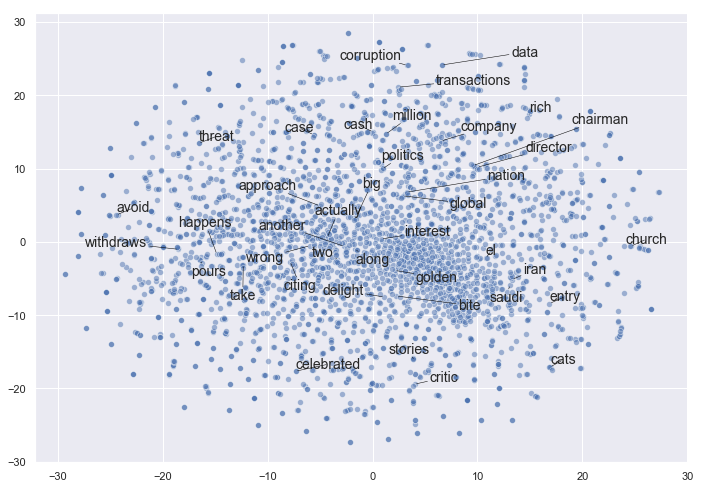

In [8]:
sns.set()

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()


In [9]:
fig = {
    'data': [
  		{
  			'x': tsne_df[:, 0], 
        	'y': tsne_df[:, 1], 
        	'text': df.index,
            "mode": "markers"
        }]}   

py.plot(fig)


'https://plot.ly/~nichelle/55'

In [10]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)


In [11]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array


0 docs removed
0 docs removed


/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning:

invalid value encountered in sqrt



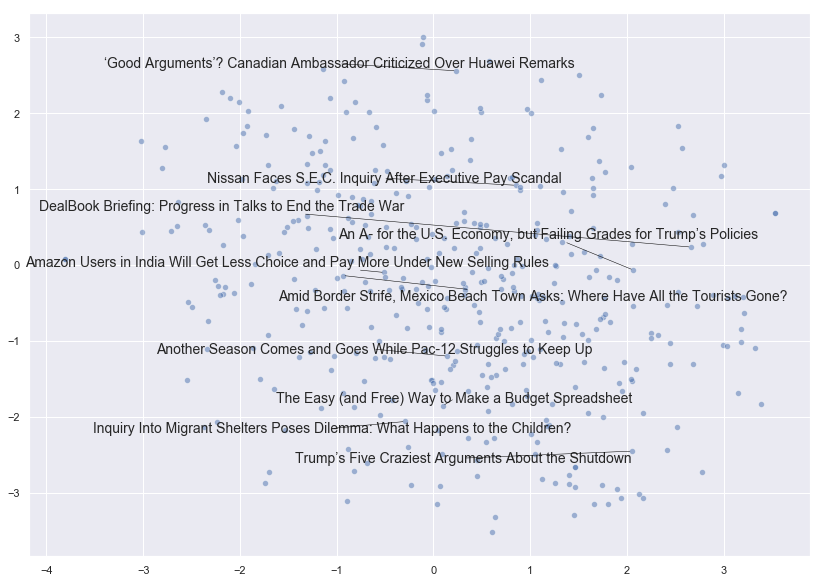

In [12]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()


In [13]:
fig2 = {
    'data': [
  		{
  			'x': tsne_df[:, 0], 
        	'y': tsne_df[:, 1], 
        	'text': titles_list,
            "mode": "markers"
        }]}   

py.plot(fig2)

'https://plot.ly/~nichelle/57'